#### Setup

In [3]:
!pip install shap

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

In [26]:
labels_df = pd.read_csv('/kaggle/input/gene-expression/actual.csv', index_col = 'patient')
test_df = pd.read_csv('/kaggle/input/gene-expression/data_set_ALL_AML_independent.csv')
data_df = pd.read_csv('/kaggle/input/gene-expression/data_set_ALL_AML_train.csv')
print('train_data: ',  data_df.shape, '\n test_data: ',  test_df.shape, '\n labels: ', labels_df.shape)

train_data:  (7129, 78) 
 test_data:  (7129, 70) 
 labels:  (72, 1)


In [27]:
genes = data_df['Gene Accession Number']

In [28]:
genes

0       AFFX-BioB-5_at
1       AFFX-BioB-M_at
2       AFFX-BioB-3_at
3       AFFX-BioC-5_at
4       AFFX-BioC-3_at
             ...      
7124         X83863_at
7125         Z17240_at
7126       L49218_f_at
7127       M71243_f_at
7128       Z78285_f_at
Name: Gene Accession Number, Length: 7129, dtype: object

#### Clean dataset

In [29]:
for col in data_df.columns:
    if col.startswith('call.') or col.startswith('call'):
        data_df = data_df.drop(col, axis=1)
        
for col in test_df.columns:
    if col.startswith('call.') or col.startswith('call'):
        test_df = test_df.drop(col, axis=1)
        
data_df = data_df.drop(['Gene Description', 'Gene Accession Number'], axis=1 )
test_df = test_df.drop(['Gene Description', 'Gene Accession Number'], axis=1 )

In [30]:
print('train_data: ',  data_df.shape, '\n test_data: ',  test_df.shape, '\n labels: ', labels_df.shape)

train_data:  (7129, 38) 
 test_data:  (7129, 34) 
 labels:  (72, 1)


In [31]:
label_mapping= {'ALL':0, 'AML':1}

labels_df = labels_df['cancer'].map(label_mapping)

In [32]:
X_test = test_df.T
X_train = data_df.T
y_train = labels_df[labels_df.index <= 38]
y_test = labels_df[labels_df.index > 38]

In [33]:
print(data_df.isnull().values.sum())
print(test_df.isnull().values.sum())

0
0


In [34]:
full_df = pd.concat([X_train, X_test], ignore_index=True)

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(full_df)

normalized_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
normalized_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
normalized_full_df = pd.concat([normalized_X_train, normalized_X_test], ignore_index=True)

In [43]:
selected_columns = [3300, 4534, 5253]

In [45]:
[genes[i] for i in selected_columns]

['U49248_at', 'X74262_at', 'D38073_at']

In [36]:
X_train = normalized_X_train[selected_columns]
X_test = normalized_X_test[selected_columns]

In [37]:
X_train.shape, X_test.shape

((38, 3), (34, 3))

#### Over Sampling

In [38]:
y_train.value_counts()

cancer
0    27
1    11
Name: count, dtype: int64

In [39]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train_ov, y_train_ov = oversample.fit_resample(X_train, y_train)
y_train_ov.value_counts()

cancer
0    27
1    27
Name: count, dtype: int64

#### Training

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define parameter grids for each classifier
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 10]
}

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 10]
}

lr_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Initialize classifiers
rfc = RandomForestClassifier(random_state=2024)
gbc = GradientBoostingClassifier(random_state=2024)
svm = SVC(random_state=2024)
xgb = XGBClassifier(random_state=2024)
lr = LogisticRegression(random_state=2024)

# Initialize GridSearchCV for each classifier
rf_grid_search = GridSearchCV(estimator=rfc, param_grid=rf_param_grid, cv=5, scoring='accuracy')
gb_grid_search = GridSearchCV(estimator=gbc, param_grid=gb_param_grid, cv=5, scoring='accuracy')
svm_grid_search = GridSearchCV(estimator=svm, param_grid=svm_param_grid, cv=5, scoring='accuracy')
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5, scoring='accuracy')
lr_grid_search = GridSearchCV(estimator=lr, param_grid=lr_param_grid, cv=5, scoring='accuracy')

# Perform hyperparameter tuning for each classifier
for grid_search, classifier_name in zip([rf_grid_search, gb_grid_search, svm_grid_search, xgb_grid_search, lr_grid_search],
                                        ['Random Forest', 'Gradient Boosting', 'SVM', 'XGBoost', 'Logistic Regression']):
    grid_search.fit(X_train_ov, y_train_ov)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best Parameters for {classifier_name}:", best_params)
    print(f"Best Score for {classifier_name}:", best_score)


Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best Score for Random Forest: 0.889090909090909
Best Parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best Score for Gradient Boosting: 0.889090909090909
Best Parameters for SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score for SVM: 0.9618181818181819
Best Parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best Score for XGBoost: 0.8890909090909093
Best Parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2'}
Best Score for Logistic Regression: 0.9618181818181819



15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

One or more of the test scores are no

- Selecting logistic regression

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

best_lr = LogisticRegression(C=0.1, penalty='l2', random_state=2024)
best_lr.fit(X_train_ov, y_train_ov)
y_pred_test_lr = best_lr.predict(X_test)

accuracy_test_lr = accuracy_score(y_test, y_pred_test_lr)
print("Accuracy on test set (Logistic Regression):", accuracy_test_lr)


Accuracy on test set (Logistic Regression): 0.8235294117647058


In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_pred_test_lr, y_test))

              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.93      0.68      0.79        19

    accuracy                           0.79        34
   macro avg       0.81      0.81      0.79        34
weighted avg       0.83      0.79      0.79        34



In [54]:
accuracy = accuracy_score(y_pred_test_lr, y_test)
precision = precision_score(y_pred_test_lr, y_test)
recall = recall_score(y_pred_test_lr, y_test)
f1 = f1_score(y_pred_test_lr, y_test)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8235294117647058
Precision: 0.9285714285714286
Recall: 0.7222222222222222
F1-score: 0.8125000000000001


#### Shap

In [52]:
column_mapping = {
    3300: genes[3300], 
    4534: genes[4534],  
    5253: genes[5253]   
}

# Rename the columns using the mapping
X_train_ov.rename(columns=column_mapping, inplace=True)

In [89]:
# compute SHAP values
explainer = shap.Explainer(best_lr, X_train_ov)
shap_values = explainer(X_train_ov)

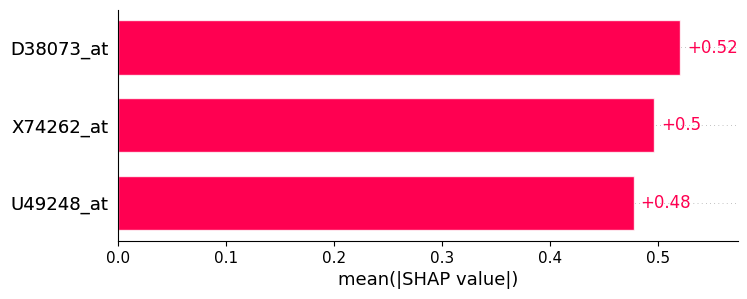

In [56]:
shap.plots.bar(shap_values)

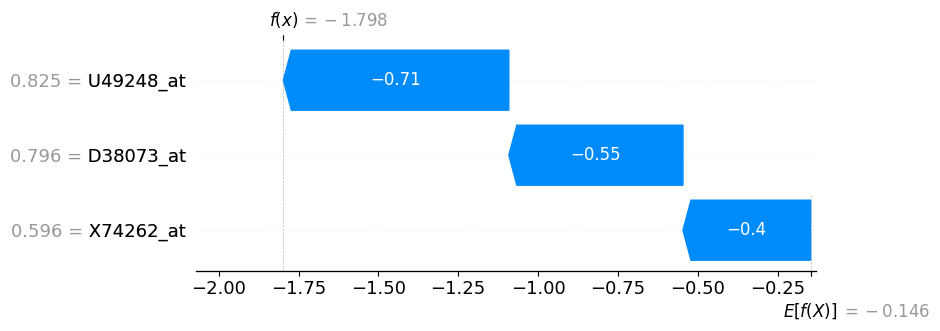

In [57]:
shap.plots.waterfall(shap_values[0])

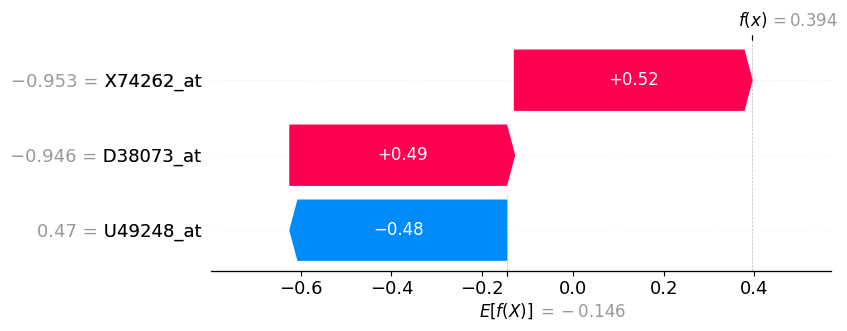

In [65]:
shap.plots.waterfall(shap_values[30])

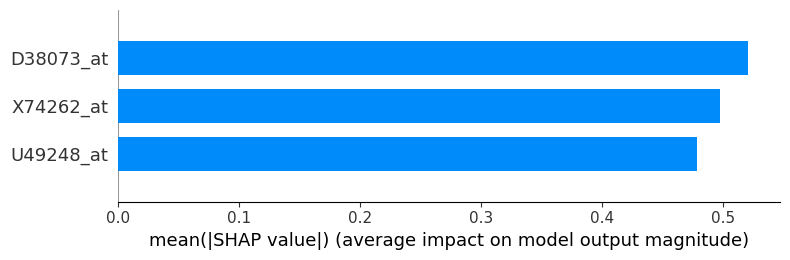

In [77]:
shap.summary_plot(shap_values, X_train_ov, plot_type="bar", color_bar=True)

#### Clustering

- Selecting DBSCAN

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


kmeans = KMeans(n_clusters=2, random_state=2024)
kmeans.fit(normalized_full_df[selected_columns])

cluster_labels = kmeans.labels_

mapped_cluster_labels = cluster_labels.copy()
mapped_cluster_labels[cluster_labels == 0] = 1
mapped_cluster_labels[cluster_labels == 1] = 0

accuracy = accuracy_score(labels_df, mapped_cluster_labels)
precision = precision_score(labels_df, mapped_cluster_labels)
recall = recall_score(labels_df, mapped_cluster_labels)
f1 = f1_score(labels_df, mapped_cluster_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.5694444444444444
Precision: 0.4444444444444444
Recall: 0.96
F1-score: 0.6075949367088608


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [76]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(normalized_full_df[selected_columns])

core_points_mask = dbscan.labels_ != -1  
outliers_mask = dbscan.labels_ == -1     

predicted_labels = core_points_mask.astype(int)

accuracy = accuracy_score(labels_df, predicted_labels)
precision = precision_score(labels_df, predicted_labels)
recall = recall_score(labels_df, predicted_labels)
f1 = f1_score(labels_df, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.6944444444444444
Precision: 0.5428571428571428
Recall: 0.76
F1-score: 0.6333333333333332


In [58]:
from sklearn.cluster import OPTICS
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

optics = OPTICS(min_samples=5, xi=0.05)
optics.fit(normalized_full_df[selected_columns])

core_distances = optics.reachability_[optics.ordering_]
predicted_labels = (core_distances < 0).astype(int)

mapped_cluster_labels = predicted_labels.copy()
mapped_cluster_labels[cluster_labels == 0] = 1
mapped_cluster_labels[cluster_labels == 1] = 0

accuracy = accuracy_score(labels_df, mapped_cluster_labels)
precision = precision_score(labels_df, mapped_cluster_labels)
recall = recall_score(labels_df, mapped_cluster_labels)
f1 = f1_score(labels_df, mapped_cluster_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.5694444444444444
Precision: 0.4444444444444444
Recall: 0.96
F1-score: 0.6075949367088608


In [64]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

spectral = SpectralClustering(n_clusters=2, gamma=1.0)
cluster_labels = spectral.fit_predict(normalized_full_df[selected_columns])

accuracy = accuracy_score(labels_df, cluster_labels)
precision = precision_score(labels_df, cluster_labels)
recall = recall_score(labels_df, cluster_labels)
f1 = f1_score(labels_df, cluster_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.6111111111111112
Precision: 0.47058823529411764
Recall: 0.96
F1-score: 0.631578947368421


In [63]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(normalized_full_df[selected_columns])

probs = gmm.predict_proba(normalized_full_df[selected_columns])
predicted_labels = (probs[:, 1] > probs[:, 0]).astype(int)

mapped_cluster_labels = predicted_labels.copy()
mapped_cluster_labels[cluster_labels == 0] = 1
mapped_cluster_labels[cluster_labels == 1] = 0

accuracy = accuracy_score(labels_df, mapped_cluster_labels)
precision = precision_score(labels_df, mapped_cluster_labels)
recall = recall_score(labels_df, mapped_cluster_labels)
f1 = f1_score(labels_df, mapped_cluster_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.6111111111111112
Precision: 0.47058823529411764
Recall: 0.96
F1-score: 0.631578947368421


In [66]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
cluster_labels = agg_clustering.fit_predict(normalized_full_df[selected_columns])

mapped_cluster_labels = cluster_labels.copy()
mapped_cluster_labels[cluster_labels == 0] = 1
mapped_cluster_labels[cluster_labels == 1] = 0

# Step 4: Evaluate
accuracy = accuracy_score(labels_df, mapped_cluster_labels)
precision = precision_score(labels_df, mapped_cluster_labels)
recall = recall_score(labels_df, mapped_cluster_labels)
f1 = f1_score(labels_df, mapped_cluster_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.4305555555555556
Precision: 0.3787878787878788
Recall: 1.0
F1-score: 0.5494505494505494


In [73]:
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

birch = Birch(n_clusters=2, threshold=0.5, branching_factor=50)
birch.fit(normalized_full_df[selected_columns])

cluster_labels = birch.predict(normalized_full_df[selected_columns])

mapped_cluster_labels = cluster_labels.copy()
mapped_cluster_labels[cluster_labels == 0] = 1
mapped_cluster_labels[cluster_labels == 1] = 0

accuracy = accuracy_score(labels_df, mapped_cluster_labels)
precision = precision_score(labels_df, mapped_cluster_labels)
recall = recall_score(labels_df, mapped_cluster_labels)
f1 = f1_score(labels_df, mapped_cluster_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.3888888888888889
Precision: 0.36231884057971014
Recall: 1.0
F1-score: 0.5319148936170213
